In [1]:
import torch
import numpy as np

# Tensors

## Creating Tensors (just like numpy)

In [12]:
data = [[2, 2], [3, 4]]
arr = np.array(data)

x_torch = torch.tensor(data)
y_torch = torch.ones(2,2)
y_torch = torch.zeros_like(x_torch)
z_torch = torch.rand((3,1))
y_torch = torch.rand_like(y_torch, dtype = torch.float)
z_torch = torch.from_numpy(arr)

arr = z_torch.numpy()

## Attributes of the Tensor

In [13]:
print(x_torch.dtype)
print(x_torch.shape)
print(x_torch.device)
if torch.cuda.is_available():
    print("GPU is available on this laptop")
    tensor = x_torch.to('cuda')

torch.int64
torch.Size([2, 2])
cpu


In [15]:
t1 = torch.cat([y_torch, z_torch], dim = 1)
print(t1)

tensor([[0.0603, 0.7267, 2.0000, 2.0000],
        [0.0366, 0.4846, 3.0000, 4.0000]])


## Arithmetic Operations on the Tensor

In [23]:
y1 = x_torch @ x_torch
y1 = x_torch.matmul(x_torch)
torch.matmul(x_torch, x_torch, out=y1)

y2 = x_torch * x_torch
y2 = x_torch.mul(x_torch)
torch.mul(x_torch, x_torch, out=y2)

result = y1.sum()
print(result)
print(result.item())

tensor(62)
62


## Inplace Operations

In [27]:
print("Before z has inplace", end = ": ")
print(z_torch)
z_torch.add_(2)

print("After inplace", end = ": ")
print(z_torch)
w = z_torch.add(2)
torch.add(z_torch, 2, out=w1)

Before z has inplace
tensor([[ 8,  8],
        [ 9, 10]], dtype=torch.int32)
After inplace
tensor([[10, 10],
        [11, 12]], dtype=torch.int32)


tensor([[12, 12],
        [13, 14]], dtype=torch.int32)

# Datasets and Dataloaders
**REMEMBER**
- Datasets always have to define **transform, transform for target, origin (if it is from cloud, download or not)**

In [11]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os

## Sample Dataset from PyTorch

In [12]:
training_data = datasets.FashionMNIST(
    root="data", download=True, train=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data", download=True, train=False, transform=ToTensor()
)
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

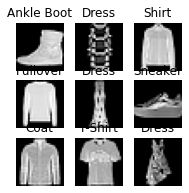

In [21]:
figure = plt.figure(figsize=(3,3))
rows, cols = 3, 3
for i in range(1, rows*cols + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap = 'gray')
plt.show()

## Custom Dataset

In [16]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": img, "label": label}
        return sample 

## DataLoader
DataLoader allows us to load data in **minibatches** instead of only getting one unit of data at a time (we can notice this from CustomImageDataset's `__getitem__()`)

In [18]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

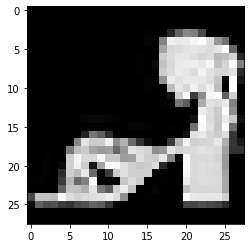

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 5, Sandal


In [28]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = 'gray')
plt.show()

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"Label: {label}, {labels_map[label.item()]}")

# Transforms

In [30]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [32]:
ds = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor(),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, idx=torch.tensor(y), value=1)
    )
)

# Building Neural Network
*Please run part 2's first cell*  

**Building Neural Network**
> 1. A layer is called a 'module'. To build more complex neural networks, *each neural network* is also a 'module'.
> 2. A neural network class must have two functions: `__init__()` and `forward()`
>   - `__init__()`: must have two components: how to treat the input especially image with more than 1 dimension (`flatten`), its actual structure (`Sequential`)
>   - `forward()`: will be called automatically when data are passed through. When building it, **assume that we are handling a piece of data**. eg, if we pass in 3 pieces of sample data, consider the dimension of **one** piece only
> 3. Layers of the network: 
>   - Linear: just like linear regression with weight m and bias c (y=mx+c)
>   - Non-linear activation (eg. ReLU): complex mappings between input and outputs. Just like adjusting the fuzzy sets in the fuzzy partition
  
**Supply Input and Get Output**  
> 4. Getting the ouput: the output**s** are called logits. Determine the largest value, then select its argument (hence argmax). But the values must be first normalised to probabilities before SoftMax can find. 

**Retrieve Parameters**

In [34]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Building Neural Network

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features = 28*28, out_features = 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## Forget about training data. First know how to input data and get the output

In [33]:
img, label = training_data[0]  # 1. get input data
logits = model(img)            # 2. pass to model to get result layer    
softmax = nn.Softmax(dim = 1)  # 3. Softmax can double check that sum of normalised values along dim=1 is 1.0
pred_prob = softmax(logits)    # 4. Softmax normalises logits (-inf, inf) to [0,1] for dim=1
y_pred = pred_prob.argmax(1)   # 5. Takagi-Sugeno-Kang's Layer 5: Real defuzzification layer
print(f'Predicted class: {labels_map[y_pred.item()]}')

Predicted class: Bag


## Understand Model Parameters

In [36]:
for name, param in model.named_parameters():
    print(f'Layer: {name}\nParameter size: {param.size()}\nParameter sneakpeak: {param[:2]}\n\n')

Layer: linear_relu_stack.0.weight
Parameter size: torch.Size([512, 784])
Parameter sneakpeak: tensor([[ 0.0271, -0.0185, -0.0248,  ...,  0.0182,  0.0247, -0.0026],
        [-0.0067,  0.0281,  0.0337,  ...,  0.0300,  0.0115,  0.0222]],
       grad_fn=<SliceBackward>)


Layer: linear_relu_stack.0.bias
Parameter size: torch.Size([512])
Parameter sneakpeak: tensor([-0.0091,  0.0145], grad_fn=<SliceBackward>)


Layer: linear_relu_stack.2.weight
Parameter size: torch.Size([512, 512])
Parameter sneakpeak: tensor([[ 0.0090, -0.0073, -0.0063,  ...,  0.0243, -0.0339,  0.0210],
        [ 0.0135, -0.0366, -0.0116,  ..., -0.0233, -0.0359,  0.0034]],
       grad_fn=<SliceBackward>)


Layer: linear_relu_stack.2.bias
Parameter size: torch.Size([512])
Parameter sneakpeak: tensor([0.0430, 0.0009], grad_fn=<SliceBackward>)


Layer: linear_relu_stack.4.weight
Parameter size: torch.Size([10, 512])
Parameter sneakpeak: tensor([[-0.0210, -0.0166, -0.0221,  ..., -0.0407, -0.0127,  0.0132],
        [ 0.0379, -